# LSTM Decoder-Encoder modell

### Beskrivning hur koden körs

##### **1. Importerad data** 
 - FastText för ordvektorer: https://fasttext.cc/docs/en/crawl-vectors.html
 - Litet Eng-Fra korpus: https://www.manythings.org/anki/
 
##### **2. Nedladdad data**
 - Vikter för LSTM Encoder - Decoder nätverk för units = 128

##### **3. Importerade bibliotek**
 - Keras
 - Pandas
 - Numpy
 - Matplotlib

##### **4. Struktur av kod**

 1. Rensa text och dela upp engelska och franska meningar
 2. Undersök struktur på data så som max längd på mening, antal unika ord (kommer användas vid träning)
 3. Skapa en generator för träning
 4. Skapa sekvens till sekvens modell med KERAS
 5. Kompiler modell och börja träna
 6. Möjlighet att ladda upp förtränade vikter av modellen för inter
 6. Skapa modell för prediktion/interferens och ladda upp vikter från träning
 7. Generera meningar rekursivt med interferens modellen

### Ord Embedding från FastText 

In [1]:
import fasttext.util

In [2]:
ft_eng = fasttext.load_model('cc.en.300.bin')
ft_fra = fasttext.load_model("cc.fr.300.bin")

## Importerade bibliotek

In [3]:
from __future__ import print_function

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import string
import random
from unicodedata import normalize

Using TensorFlow backend.


## Preprocess

Rensa data från antingen fra2.txt. Skapar listor med meningar för båda språk samt två vokabulär med unika ord.

In [4]:

_SOS = "<SOS> " #Start of string
_EOS = " <EOS>" #End of string

file_input = "fra2.txt" #Not modified
num_samples = 50000

def preprocess(file_input, num_samples):
    
    f_input = open(file_input,"r", encoding="utf-8")
    
    input_sentences = [] 
    output_sentences = []
    
    input_vocab = set() 
    output_vocab = set() 
    lines_input = f_input.readlines()
    
    lines_input = lines_input[:num_samples]
    random.Random(1).shuffle(lines_input)
    
    for i in range(len(lines_input)):
        
        input_sentence, output_sentence, _ = lines_input[i].translate(str.maketrans("", "", string.punctuation + string.digits)).split("\t")
        input_sentence, output_sentence = input_sentence.lower(), output_sentence.lower() 

        output_sentence = _SOS + output_sentence + _EOS
        input_sentences.append(input_sentence.split())
        output_sentences.append(output_sentence.split())

        for word in input_sentence.split():
            if word not in input_vocab:
                input_vocab.add(word)
                
        for word in output_sentence.split():
            if word not in output_vocab:
                output_vocab.add(word)
        

    return input_sentences, output_sentences, input_vocab, output_vocab

input_sentences, output_sentences, input_vocab, output_vocab = preprocess(file_input, num_samples)


### Undersöker datans struktur för träning

Dessa parametrar krävs för att kunna utföra träningen. Man kommer behövs skapa vektorer med lika stor längd vilket kommer vara max längden på meningarna i båda korpus.

In [5]:
input_vocab = sorted(list(input_vocab))
output_vocab = sorted(list(output_vocab))

num_input_words = len(input_vocab)+1 #Adding +1 because of padding
num_output_words = len(output_vocab)+1 #Adding +1 because of padding

max_input_sentence_size = max([len(sen) for sen in input_sentences])
max_output_sentence_size = max([len(sen) for sen in output_sentences])

print("Number of English words", num_input_words)
print("Number of French words", num_output_words)
print("The longest English sentence is:", max_input_sentence_size)
print("The longest French sentence is:", max_output_sentence_size)

Number of English words 5998
Number of French words 12613
The longest English sentence is: 7
The longest French sentence is: 16


#### Distribution av längden på meningarna 

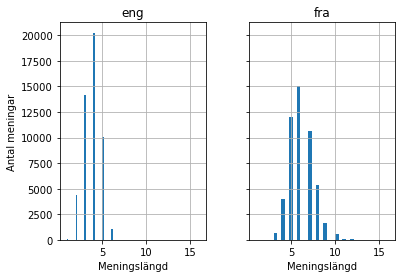

In [6]:
def distribution(in_txts, out_txts):
    in_l = []
    out_l = []
    for i in in_txts: in_l.append(len(i))
    for i in out_txts: out_l.append(len(i))

    length_df = pd.DataFrame({'eng':in_l, 'fra':out_l})
    histo = length_df.hist(bins = 30, sharex=True, sharey=True,)

    for ax in histo.flatten():
        ax.set_xlabel("Meningslängd")
        ax.set_ylabel("Antal meningar")
    plt.show()
    #plt.savefig("histoShuffleFirst20k")
distribution(input_sentences, output_sentences)

### Dictionaries

Skapar två dictionaries för att kunna hämta vilket ord har vilket index. Varför i+1 används är för att 0 kommer anses som padding i ett senare skede.

In [7]:
input_word2idx = dict([(word, i+1) for i, word in enumerate(input_vocab)])
output_word2idx = dict([(word, i+1) for i, word in enumerate(output_vocab)])

input_idx2word = dict([(i, word) for word, i in input_word2idx.items()])
output_idx2word = dict([(i, word) for word, i in output_word2idx.items()])

#### Träning/Test delning

40000 10000 40000 10000


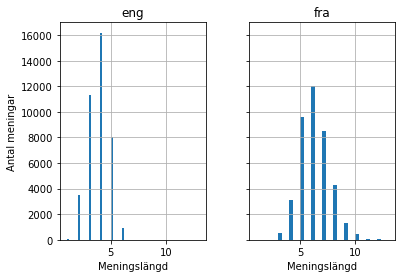

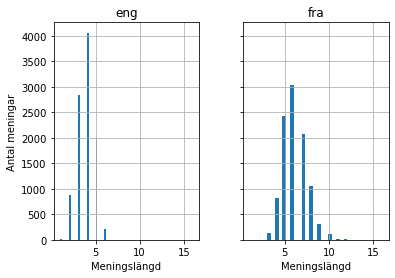

In [8]:
input_training, input_test, output_training, output_test = train_test_split(input_sentences, 
                                                                            output_sentences, 
                                                                            test_size = 0.2, 
                                                                            random_state = 0)
print(len(input_training), len(input_test), len(output_training), len(output_test))

distribution(input_training, output_training)
distribution(input_test, output_test)

#### **Parametrar för träning**

In [9]:
training_samples = len(input_training)
validation_samples = len(input_test)
batch_size = 256
EPOCHS = 50
NUM_HIDDEN_UNITS = 128
EMBEDDING_SIZE = 300

### Generator-funktion för att generera batch

Skapar 3 matriser, 2 är för kodnings input & avkodnings input. Den tredje är skiftat så att <SOS> inte tas med för att kunna använda Teacher Forcing så att träningen går snabbare.

In [51]:

def batch_generator(X, y, batch_size, index = None):
    #Shuffle for each epoch for generalization
    if index == None:
        training = list(zip(X, y))
        random.shuffle(training)
        X, y = zip(*training)
    while True:
        #For inference modell
        if index != None and batch_size == 1:
            encoder_input = np.zeros((batch_size, max_input_sentence_size),dtype='float32')
            decoder_input = np.zeros((batch_size, max_output_sentence_size),dtype='float32')
            decoder_output = np.zeros((batch_size, max_output_sentence_size, num_output_words),dtype='float32')
            for i, (input_sentence, output_sentence) in enumerate(zip(X[index:index+batch_size], y[index:index+batch_size])):
                for t, word in enumerate(input_sentence):
                    t+=1
                    encoder_input[i, -t] = input_word2idx[word]
                for t, word in enumerate(output_sentence):
                    decoder_input[i, t] = output_word2idx[word]
                    if t>0:
                        decoder_output[i, t-1, output_word2idx[word]] = 1.
                    
                yield([encoder_input, decoder_input], decoder_output)
        #For training
        else: 
            for j in range(0, len(X), batch_size):
                encoder_input = np.zeros((batch_size, max_input_sentence_size),dtype='float32')
                decoder_input = np.zeros((batch_size, max_output_sentence_size),dtype='float32')
                decoder_output = np.zeros((batch_size, max_output_sentence_size, num_output_words),dtype='float32')
                for i, (input_sentence, output_sentence) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                    for t, word in enumerate(input_sentence):
                        t+=1
                        encoder_input[i, -t] = input_word2idx[word]
                    for t, word in enumerate(output_sentence):
                        decoder_input[i, t] = output_word2idx[word]
                        if t>0:
                            decoder_output[i, t-1, output_word2idx[word]] = 1.
                    
                yield([encoder_input, decoder_input], decoder_output)

#### Skapa embedding matris för input

In [11]:
embedding_matrix_input = np.zeros((num_input_words, 300))
embedding_matrix_output = np.zeros((num_output_words, 300))

for word, i in input_word2idx.items():
    embedding_matrix_input[i] = ft_eng.get_word_vector(word) 
for word, i in output_word2idx.items():
    embedding_matrix_output[i] = ft_fra.get_word_vector(word)

print(embedding_matrix_input.shape)
print(embedding_matrix_output.shape)

    

(5998, 300)
(12613, 300)


### Encoder - Decoder struktur
**Encoder**
1. Ett Input lager för Encoder,kopplat till E2. Dimension{max_in_sen}
2. Embedding lager för Encoder, kopplat till E3.
3. LSTM Encoder, kopplat till, kopplat till D3.

**Decoder**
1. Ett Input lager för Decoder, kopplat till D2.
2. Ett Embedding lager för Decoder, kopplat till D3.
3. LSTM Decoder, kopplat till D4.
4. Softmax Dense lager till för output sannolikheter
 

In [12]:
#Encoder Architecture

encoder_input_layer = Input(shape=(None,))
embedding_encoder_layer = Embedding(num_input_words, 
                         EMBEDDING_SIZE, 
                         weights=[embedding_matrix_input], 
                         input_length=max_input_sentence_size, 
                         trainable = False, 
                         mask_zero = True)

encoder_embedding = embedding_encoder_layer(encoder_input_layer)

encoder_lstm_layer = LSTM(units=NUM_HIDDEN_UNITS, return_state=True)
encoder_outputs, hidden_state, cell_state = encoder_lstm_layer(encoder_embedding)
encoder_states = [hidden_state, cell_state] 


#Decoder Architecture
decoder_input_layer = Input(shape=(None,))
embedding_decoder_layer = Embedding(num_output_words, 
                          EMBEDDING_SIZE, 
                          weights=[embedding_matrix_output], 
                          input_length = max_output_sentence_size, 
                          trainable = False, 
                          mask_zero = True)

decoder_embedding = embedding_decoder_layer(decoder_input_layer)

decoder_lstm_layer = LSTM(units=NUM_HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _ , _ = decoder_lstm_layer(decoder_embedding, initial_state=encoder_states) 

#Softmax Arcitecture
decoder_softmax_layer = Dense(num_output_words, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)


##### *Modell sammanfattning*

In [13]:
model = Model([encoder_input_layer, decoder_input_layer], decoder_outputs)
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= opt, loss="categorical_crossentropy", metrics=["accuracy"])

### Träning av algoritm

In [29]:

history = model.fit(batch_generator(input_training, output_training, batch_size = batch_size),
                    steps_per_epoch = training_samples//batch_size,
                    epochs=EPOCHS,
                    validation_data = batch_generator(input_test, output_test, batch_size = batch_size),
                    validation_steps = validation_samples//batch_size)

Epoch 1/50
156/156 [==============================] - 110s 703ms/step - loss: 1.8583 - accuracy: 0.2221 - val_loss: 1.6193 - val_accuracy: 0.2829
Epoch 2/50
156/156 [==============================] - 109s 696ms/step - loss: 1.2985 - accuracy: 0.3311 - val_loss: 1.1290 - val_accuracy: 0.3640
Epoch 3/50
156/156 [==============================] - 108s 694ms/step - loss: 0.9884 - accuracy: 0.3882 - val_loss: 0.9777 - val_accuracy: 0.4023
Epoch 4/50
156/156 [==============================] - 109s 701ms/step - loss: 0.8196 - accuracy: 0.4258 - val_loss: 0.8863 - val_accuracy: 0.4299
Epoch 5/50
156/156 [==============================] - 108s 693ms/step - loss: 0.6952 - accuracy: 0.4582 - val_loss: 0.8305 - val_accuracy: 0.4489
Epoch 6/50
156/156 [==============================] - 108s 695ms/step - loss: 0.6011 - accuracy: 0.4862 - val_loss: 0.7948 - val_accuracy: 0.4649
Epoch 7/50
156/156 [==============================] - 112s 717ms/step - loss: 0.5298 - accuracy: 0.5127 - val_loss: 0.7774 -

### Plottning av modellens säkerhet och förlust

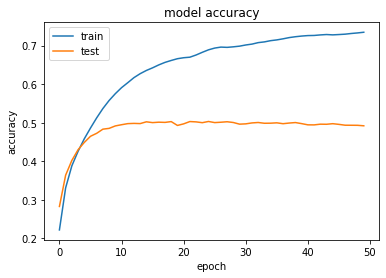

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("LR001K50kU128B256ACC")

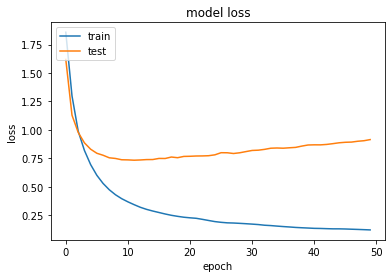

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("LR001K50kU128B256LOSS")

## Inference modellen

>**Här görs två nya modeller med dem vikter som har tränats tidigare. En som är kodaren och en som är avkodaren. Kodaren är endast tillför att förse avkodaren med initiala tillstånden c & h. Resten sköter avkodaren som helt enkelt arbetar rekursivt för att få ut en slutlig mening.**

In [14]:

enc_model = Model(encoder_input_layer, encoder_states)

decoder_input_hidden_state = Input(shape=(NUM_HIDDEN_UNITS,))
decoder_input_cell_state = Input(shape=(NUM_HIDDEN_UNITS,))
decoder_input_states = [decoder_input_hidden_state, decoder_input_cell_state ]

decoder_embedding_input = embedding_decoder_layer(decoder_input_layer)

decoder_outputs, hidden_state, cell_state = decoder_lstm_layer(decoder_embedding_input, initial_state=decoder_input_states)
decoder_output_states = [hidden_state, cell_state]
decoder_outputs = decoder_softmax_layer(decoder_outputs)

dec_model = Model([decoder_input_layer] + decoder_input_states, [decoder_outputs] + decoder_output_states)



In [33]:
model.save_weights("lstm_hidden_layers_128.h5")

In [15]:
model.load_weights('lstm_hidden_layers_128.h5')

## Prediktion av mening

>**Här utförs den rekursiva prediktionen där vi använder Greedy Search för att idenfiera vilket index har högst sannolikhet mellan output orden m.h.a argmax. När detta ord är hittat, adderas den till prediktionen och sedan används för nästa iteration.**

In [17]:
def decode_sequence(input_seq):
    states_value = enc_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = output_word2idx["<SOS>"]
    stop_condition = False
    decoded_sentence = list()
    decode_sentence_text = ""
    while not stop_condition:
        output_tokens, h, c = dec_model.predict([target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = output_idx2word[sampled_token_index]
    
    
        if sampled_word == "<EOS>" or len(decoded_sentence) > max_output_sentence_size:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)
            decode_sentence_text = decode_sentence_text + " " + sampled_word
            
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = output_word2idx[sampled_word]
        states_value = [h, c]
    return decode_sentence_text


### Funktion för att generera kodning-matris för godtycklig engelsk mening

In [38]:
def new_sentence(input_sentence):
    encoder_input = np.zeros((1, max_input_sentence_size),dtype='float32')
    for t, word in enumerate(input_sentence):
        t+=1
        encoder_input[0, -t] = input_word2idx[word]  
    return encoder_input

#### Översätta ny mening
>**Här behöver man skriva in en mening på engelska. Därefter kan man se hur bra modeller är i jämförelse
med riktiga översättningen**

In [43]:
while True: 
    input_sentence = input("Skriv in en mening på engelska: ").lower()
    if input_sentence == "exit":
        break
    try:
        for word in input_sentence.split():
            input_word2idx[word]
        break
    except:
        print("Din mening innehåller ord som inte modellen är tränad på. Testa igen!")
            

Skriv in en mening på engelska:  I LIKE CaNDY


In [44]:
sentence_data = new_sentence_generator(input_sentence.split())
decoded_sentence = decode_sequence(sentence_data)
print("Engelska mening:", input_sentence)
print("Franska översatta mening:", decoded_sentence)

Engelska mening: i like candy
Franska översatta mening:  jaime le fromage


#### Översätta mening från träningsdata
>**Här generas 10 slumpartade meningar från träningskorpuset för att identifiera hur bra modellen tränades**

In [53]:
predicted_sentences = list()
for i in random.sample(range(0, len(input_training)-1), 10):
    train_gen = batch_generator(input_training, output_training, batch_size = 1, index = i)
    (input_seq, actual_output), _ = next(train_gen)

    decoded_sentence = decode_sequence(input_seq)
    print("Engelsk mening:",input_training[i])
    print("Fransk mening:", output_training[i])
    print("Förutspådd mening:", decoded_sentence)
    print()

Engelsk mening: ['i', 'hardboiled', 'an', 'egg']
Fransk mening: ['<SOS>', 'jai', 'cuit', 'un', 'œuf', 'dur', '<EOS>']
Förutspådd mening:  jaime une nouvelle carte

Engelsk mening: ['this', 'is', 'boring']
Fransk mening: ['<SOS>', 'cest', 'ennuyeux', '<EOS>']
Förutspådd mening:  cest ennuyeux

Engelsk mening: ['im', 'aware', 'of', 'that']
Fransk mening: ['<SOS>', 'jen', 'suis', 'consciente', '<EOS>']
Förutspådd mening:  jen suis consciente

Engelsk mening: ['ill', 'lend', 'it', 'to', 'you']
Fransk mening: ['<SOS>', 'je', 'vous', 'la', 'prêterai', '<EOS>']
Förutspådd mening:  je te le prêterai

Engelsk mening: ['tom', 'came', 'home']
Fransk mening: ['<SOS>', 'tom', 'est', 'rentré', 'à', 'la', 'maison', '<EOS>']
Förutspådd mening:  tom est rentré chez moi

Engelsk mening: ['youre', 'no', 'saint']
Fransk mening: ['<SOS>', 'vous', 'nêtes', 'pas', 'un', 'saint', '<EOS>']
Förutspådd mening:  tu nes pas un saint

Engelsk mening: ['i', 'cant', 'come', 'now']
Fransk mening: ['<SOS>', 'je', 'ne',